## <b>Описание данных и задания </b>

### <b>Техническое задание </b>

Заказчик собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

### <b>taxi.csv</b>

datetime - дата и время 
<br>num_orders - количество заказов

## <b>Импорт библиотек</b>

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings('ignore')

In [2]:
line = '-'*80

#Информация о таблице
def percentage_passes (dataset):
    print(dataset.info())
    print(line)
    print('Количество пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.mean(dataset[col].isnull())
        print(col, datcol)  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())

## <b>Загрузка и изучение данных</b>

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0],  parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
percentage_passes(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
--------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
num_orders 0.0
--------------------------------------------------------------------------------
Количество дубликатов - 26415


<AxesSubplot:xlabel='datetime'>

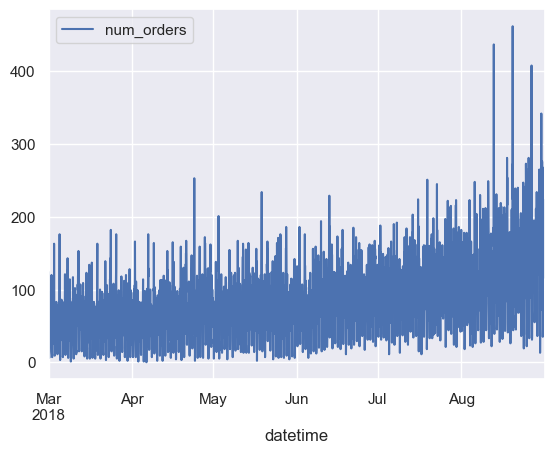

In [6]:
data = data.resample('1H').sum() 
sns.set()
data.plot()

<b>Вывод</b>
<br>Данные предоставлены в период за полгода 2018 года, с марта по август (включительно). Виден большой скачок количества заказов примерно в середине августа. До августа количество заказов распределено примерно одинаково по месяцам. Пропусков нет, но есть дубликаты. Дубликаты трогать нет смысла, так как по сути есть только один столбец.

## <b>Исследовательский анализ</b>

In [7]:
decomposed = seasonal_decompose(data) 

Посмотрю тренд за весь набор данных.

Text(0.5, 1.0, 'Trend')

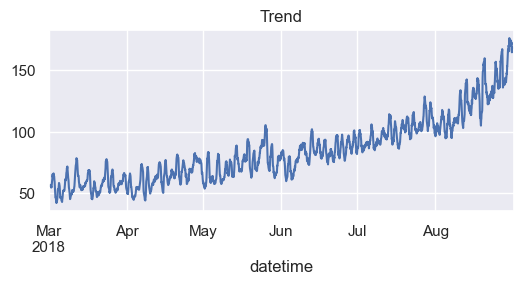

In [8]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')



Тренд растет от месяца к месяцу и достигает своего пика в конце августа.

Теперь посмотрю тренд на паре месяцев.

Text(0.5, 1.0, 'Trend')

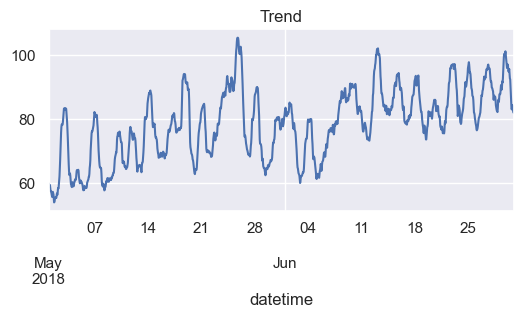

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-05-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Trend')

Видно, что в начале месяца количество заказов падает, а вот уже в середине и конце неплохо возрастает. 

Посмотрю, как выглядит тренд по неделям. Возьму 3 случайные недели.

Text(0.5, 1.0, 'Trend')

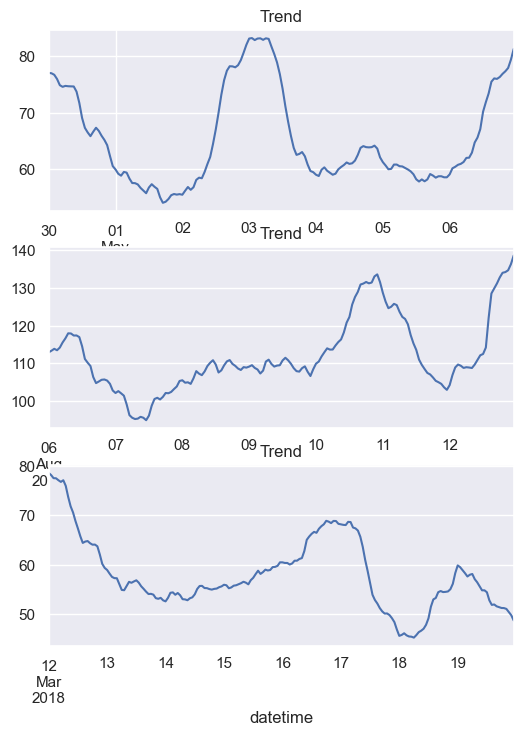

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-04-30':'2018-05-06'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.trend['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.trend['2018-03-12':'2018-03-19'].plot(ax=plt.gca())
plt.title('Trend')

Видна тенденция что в середине недели или на выходных количество заказов растет.

<b>Вывод</b>
<br>К концу года количество заказов стремительно начинает расти. По месяцам можно увидеть, что в конце месяца заков больше, чем в начале (что совпадает с первым утверждением). По неделям же можно сказать, что не только выходные повышают количество заказов, но и середина недели.

## <b>Создание признаков</b>

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 50)

data = data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,62.82
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.84
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.42
2018-03-03 05:00:00,15,5,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,59.88
2018-03-03 06:00:00,9,5,6,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,58.86


## <b>Обучение моделей</b>

Оставлю от тестовой выборки только 10%

In [12]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

print(f"Строк в тренировочном датасете - {len(X_train)}") 
print(line)
print(f"Строк в тестовом датасете - {len(X_test)}")

Строк в тренировочном датасете - 3929
--------------------------------------------------------------------------------
Строк в тестовом датасете - 437


### <b>LinearRegression</b>

In [13]:
model_linearregression = LinearRegression()

model_linearregression.fit(X_train, y_train)

y_pred_lr_train = model_linearregression.predict(X_train)

rmse_lr_train = mean_squared_error(y_train, y_pred_lr_train, squared=False) 

print("RMSE LinearRegression на тренировочной выборке-", round(rmse_lr_train, 2))

y_pred_lr_test = model_linearregression.predict(X_test)

rmse_lr_test = mean_squared_error(y_test, y_pred_lr_test, squared=False) 

print(line)
print("RMSE LinearRegression на тестовой выборке-", round(rmse_lr_test, 2))

RMSE LinearRegression на тренировочной выборке- 25.83
--------------------------------------------------------------------------------
RMSE LinearRegression на тестовой выборке- 45.18


### <b>DecisionTreeRegressor</b>

In [14]:
model_decisiontreeregressor = DecisionTreeRegressor(random_state=42, criterion='mse')

hyperparams = [{'splitter': [' best', 'random'],
               'max_depth': range(2, 6),
               'min_samples_split': range(1, 3)}]

decisiontreeregressor = GridSearchCV(model_decisiontreeregressor, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

decisiontreeregressor.fit(X_train, y_train)

print("Лучшие параметры модели DecisionTreeRegressor -", decisiontreeregressor.best_estimator_)

y_pred_dtr_train = decisiontreeregressor.best_estimator_.predict(X_train)

rmse_dtr_train = mean_squared_error(y_train, y_pred_dtr_train, squared=False) 

print(line)
print("RMSE DecisionTreeRegressor на тренировочной выборке-", round(rmse_dtr_train, 2))

y_pred_dtr_test = decisiontreeregressor.best_estimator_.predict(X_test)

rmse_dtr_test = mean_squared_error(y_test, y_pred_dtr_test, squared=False) 

print(line)
print("RMSE DecisionTreeRegressor на тестовой выборке-", round(rmse_dtr_test, 2))

Лучшие параметры модели DecisionTreeRegressor - DecisionTreeRegressor(max_depth=5, random_state=42, splitter='random')
--------------------------------------------------------------------------------
RMSE DecisionTreeRegressor на тренировочной выборке- 27.83
--------------------------------------------------------------------------------
RMSE DecisionTreeRegressor на тестовой выборке- 56.74


### <b>XGBRegressor</b>

In [15]:
model_xgbregressor = XGBRegressor(objective='reg:squarederror')

hyperparams = [{'max_depth': [3, 5, 7],
                'n_estimators': [50, 100, 150],
                'learning_rate': [0.01, 0.1, 0.2]}]

xgbregressor = GridSearchCV(model_xgbregressor, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

xgbregressor.fit(X_train, y_train)

print("Лучшие параметры модели XGBRegressor -", xgbregressor.best_estimator_)

y_pred_xgbr_train = xgbregressor.best_estimator_.predict(X_train)

rmse_xgbr_train = mean_squared_error(y_train, y_pred_xgbr_train, squared=False) 

print(line)
print("RMSE XGBRegressor на тренировочной выборке-", round(rmse_xgbr_train, 2))

y_pred_xgbr_test = xgbregressor.best_estimator_.predict(X_test)

rmse_xgbr_test = mean_squared_error(y_test, y_pred_xgbr_test, squared=False) 

print(line)
print("RMSE XGBRegressor на тестовой выборке-", round(rmse_xgbr_test, 2))

Лучшие параметры модели XGBRegressor - XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
--------------------------------------------------------------------------------
RMSE XGBRegressor на тренировочной выборке- 14.53
--------------------------------------------------------------------------------
RMSE XG

### <b>LGBMRegressor</b>

In [16]:
model_lgbmregressor = LGBMRegressor(learning_rate=0.1, num_leaves=10, random_state=42)

hyperparams = [{'learning_rate': [0.1, 0.2],
                'num_leaves': [10, 50, 100]}]

lgbmregressor = GridSearchCV(model_lgbmregressor, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')


lgbmregressor.fit(X_train, y_train)

print("Лучшие параметры модели LGBMRegressor -", lgbmregressor.best_estimator_)

y_lgbmr_lgbm_train = lgbmregressor.best_estimator_.predict(X_train)

rmse_lgbm_train = mean_squared_error(y_train, y_lgbmr_lgbm_train, squared=False) 

print("RMSE LGBMRegressor на тренировочной выборке-", round(rmse_lgbm_train, 2))

y_pred_lgbm_test = lgbmregressor.best_estimator_.predict(X_test)

rmse_lgbm_test = mean_squared_error(y_test, y_pred_lgbm_test, squared=False) 

print(line)
print("RMSE LGBMRegressor на тестовой выборке-", round(rmse_lgbm_test,2))

  File "C:\Users\yurpa\anaconda3\envs\practicum\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\yurpa\anaconda3\envs\practicum\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\yurpa\anaconda3\envs\practicum\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\yurpa\anaconda3\envs\practicum\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4840
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 27
[LightGBM] [Info] Start training from score 78.560193
Лучшие параметры модели LGBMRegressor - LGBMRegressor(num_leaves=50, random_state=42)
RMSE LGBMRegressor на тренировочной выборке- 9.28
--------------------------------------------------------------------------------
RMSE LGBMRegressor на тестовой выборке- 39.75


### <b>Ridge</b>

In [18]:
model_ridge = Ridge()

hyperparams = [{'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],}]

ridege = GridSearchCV(model_ridge, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')


ridege.fit(X_train, y_train)

print("Лучшие параметры модели Ridge -", ridege.best_estimator_)

y_lgbmr_ridege_train = ridege.best_estimator_.predict(X_train)

rmse_ridege_train = mean_squared_error(y_train, y_lgbmr_ridege_train, squared=False) 

print("RMSE Ridge на тренировочной выборке-", round(rmse_ridege_train, 2))

y_pred_ridege_test = ridege.best_estimator_.predict(X_test)

rmse_ridege_test = mean_squared_error(y_test, y_pred_ridege_test, squared=False) 

print(line)
print("RMSE Ridge на тестовой выборке-", round(rmse_ridege_test, 2))

Лучшие параметры модели Ridge - Ridge(solver='saga')
RMSE Ridge на тренировочной выборке- 25.83
--------------------------------------------------------------------------------
RMSE Ridge на тестовой выборке- 45.19


In [19]:
column=['RMSE модели на train','RMSE модели на test']
index = ['LinearRegression', 'DecisionTreeRegressor', 'XGBRegressor', 'LGBMRegressor', 'Ridge']
data = [[25, 45],[27, 58],[18, 42],[18, 43],[25, 45]]

pd.DataFrame(data=data, index=index, columns=column)

,RMSE модели на train,RMSE модели на test
LinearRegression,25,45
DecisionTreeRegressor,27,58
XGBRegressor,18,42
LGBMRegressor,18,43
Ridge,25,45


График прогноза лучшей модели.

In [20]:
def comparison_chart_2(y_pred_1):
    start = 0
    end = 50
    
    basic_df = y_test[start:end]
    nn_df_1 = y_pred_1[start:end]

    plt.figure(figsize=(15, 7))
    plt.bar(range(start, end), basic_df, color='blue', width=1, label='Факт')
    plt.bar(range(start, end), nn_df_1, color='orange', width=0.6, label='XGBRegressor')

    

    plt.legend()
    plt.title('Факт-прогноз', fontsize=17)
    plt.xlabel('Количество заказов', fontsize=12)
    plt.ylabel('Дата', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

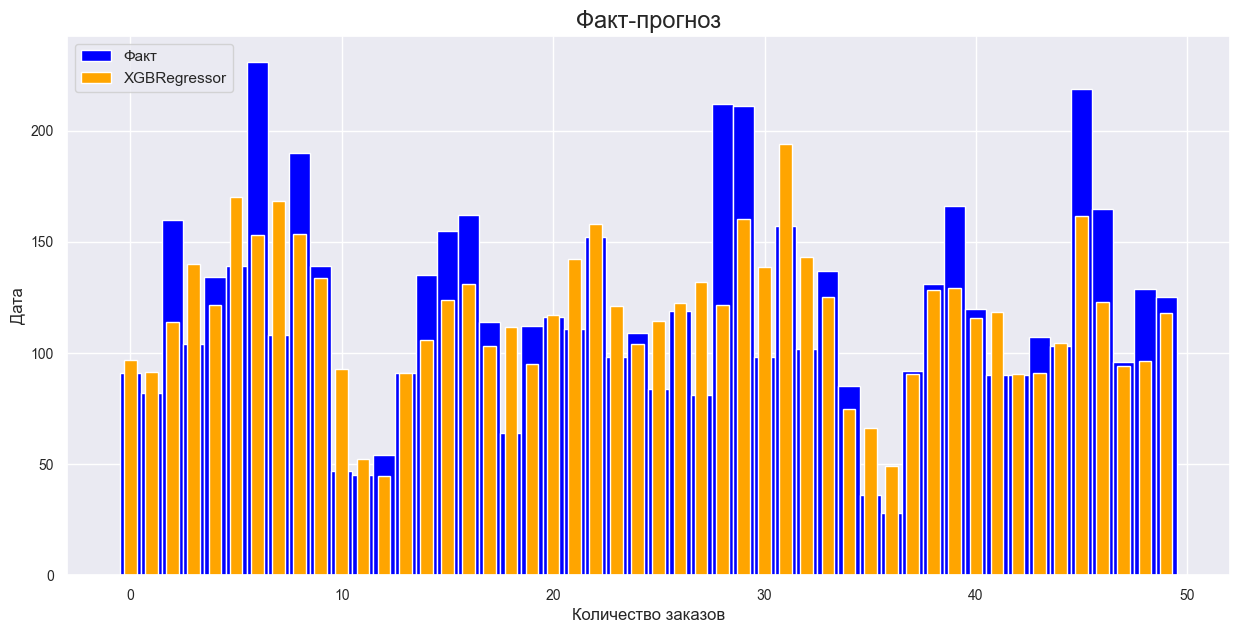

In [21]:
comparison_chart_2(y_pred_xgbr_test)

<b>Вывод</b>
<br>Лучшая модель XGBRegressor с метрикой RMSE - 42